# Agrupamiento de lenguajes a partir de redes de co-ocurrencia de textos traducidos: *Manifiesto del Partido Comunista*

Este proyecto reproduce el análisis de [Liu y Cong (2013)](https://link.springer.com/article/10.1007/s11434-013-5711-8)


## Hipótesis

Las topologías de las redes de co-ocurrencia de palabras reflejan las relaciones de parentesco entre los lenguajes.

## Predicción

La topología de las redes de co-ocurrencia de un mismo texto traducido en diferentes lenguajes, serán más similares entre sí si los lenguajes pertenecen a una misma familia lingüística. 


## Método

### 1. Definición de las redes

Se definieron un total de 31 redes de co-ocurrencia de palabras a partir de traducciones la obras *Manifiesto del partido comunista* de Karl Marx. En estas redes no dirigidas cada vértice ($v_i$) representan una palabra distinta y existe un enlcace ($e_i$) entre la palabra $v_n$ y $v_m$ si $v_n$ es vecina a $v_m$. Por ejemplo, para las oraciones "El perro está enojado con el gato. El niño está llorando.", se obtienen el siguiente conjunto de vérices ($V$) y de enlaces ($E$):

$V$ = *{el,perro,está,enojado,con,gato,.,niño,llorando}*

$E$ = *{{el,perro},{perro,está},{está,enojado},{enojado,con},{con, el}, {el,gato},{gato,.},{.,el},{el,niño},{niño,llorando},{llorando,.}}*


In [76]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import pandas as pd
import os


Texto original:
Un espectro se cierne sobre Europa: el espectro del comunismo.

Texto procesado (enlaces de la red):
['un', 'espectro']
['espectro', 'se']
['se', 'cierne']
['cierne', 'sobre']
['sobre', 'europa']
['europa', 'el']
['el', 'espectro']
['espectro', 'del']
['del', 'comunismo']
['comunismo', '.']


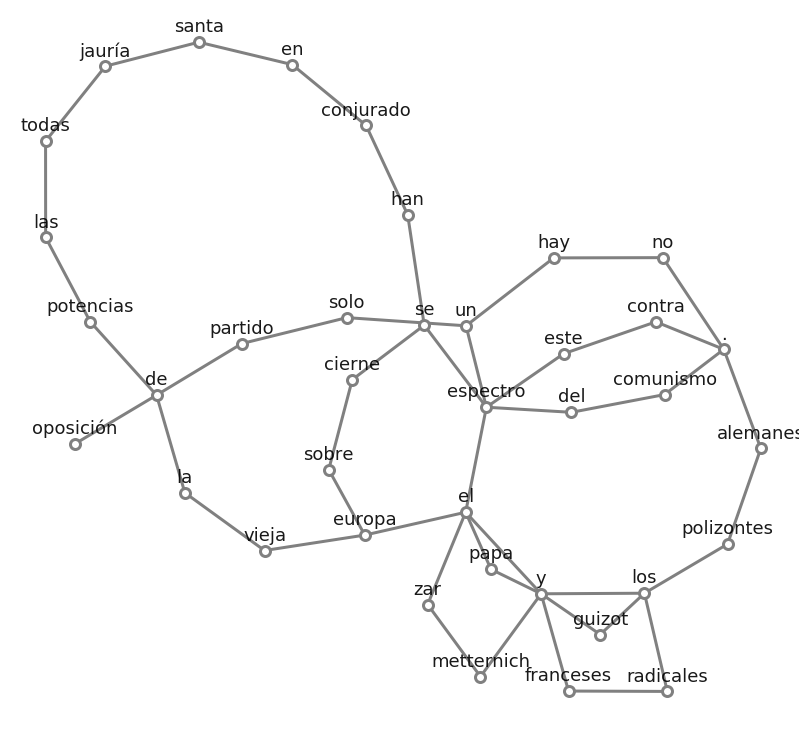

In [95]:
## se leen los archivos
obra = 'manifiesto'
textos = {}

for nombre_archivo in os.listdir('textos/' + obra):
    if(nombre_archivo[-4:] == '.txt'):
        with open('textos/' + obra + '/' + nombre_archivo) as archivo:
            idioma = nombre_archivo.split('-')[1].split('.')[0]
            textos[idioma] = archivo.read()

print('\nTexto original:')
print(textos['espanol'][:62])

## se limpian los textos
def limpiarTexto (text):
    text = text.lower()
    skips = ['...','…','’',',','„',';',':','"','“',"'",'¡','!','¿','?','\n','-','–','—','”','»','«','(',')','‘','\t\u3000\u3000','›','‹','1','2','3','4','5','6','7','8','9','0','^','ᵉ','\\ ','[','*',']','\x0c','..','’’','°']
    for skip in skips:
        text = text.replace(skip, ' ')
        text = re.sub(' +', ' ', text)
    return text

for idioma, texto in textos.items():
    textos[idioma] = limpiarTexto(texto)

## se definen los enlaces de las redes
def crearEnlaces( texto ):
    texto_lista = re.findall(r"[\w']+|[.,!?;]", texto) 
    pares_palabras = []
    for i in range( len(texto_lista) - 1):
        par = [ texto_lista[i], texto_lista[i + 1]]
        pares_palabras.append(par)
    return pares_palabras

for idioma, texto in textos.items():
    textos[idioma] = crearEnlaces(texto)

print('\nTexto procesado (enlaces de la red):')
for enlace in textos['espanol'][:10]:
    print(enlace)
    
## se grafica un ejemplo reducido de la red construida
numero_de_nodos = 50
GReducidaEjemplo = nx.Graph(textos['espanol'][:numero_de_nodos - 1])

figura = plt.figure(figsize=(11,10))
  
pos = nx.kamada_kawai_layout(GReducidaEjemplo)

nx.draw(GReducidaEjemplo,
        pos,
        node_color='w',
        edgecolors = 'grey',
        linewidths=3,
        node_size=100,
        node_shape='o',
        width=3,
        edge_color='grey')

m = 0.04
for key, value in pos.items():
    pos[key] = np.array( [(pos[key][0]), (pos[key][1]+m)] ) 
    
labels = nx.draw_networkx_labels(GReducidaEjemplo,
                                 pos,
                                 font_size = 18,
                                 alpha=0.9,) 


### 2. Análisis cuantitativo de las redes

Se calcularon las siguentes medidas para cada red:
1. número de nodos ($V$)
1. número de enlaces ($E$)
1. grado promedio (k_prom=$<k>$)
1. longitud promedio (long_prom=$L$)
1. coeficiente de clustering (clus=$C$)
1. diámetro (diam=$D$)
1. centralización de red (centralizacion=$NC$)
1. heterogeneidad de red (hetereogenedidad=$NH$)
1. exponente de mejor ajuste de la ley de potencia a la distribución de grado (ajuste_dist_grado=$\alpha_1$)
1. $R^2$ del ajuste a la ley de potencias a la distrubución de grado (ajuste_dist_grado_R_sqrt=$R^2_1$)
1. exponente de mejor ajuste de la ley de potencias a la distribución de grado de los vecinos cercanos (ajuste_dist_nadc=$\alpha_2$)
1. $R^2$ del mejor ajuste de la ley de potencias a la distribución de grado de los vecinos cercanos (ajuste_dist_nadc_R_sqrt=$R^2_2$)


In [118]:
## ESTA CELDA SE TARDA MUCHO EN CORRER
# se contruyen las redes
Gs = {}

for idioma, enlaces in textos.items():
    Gs[idioma] = nx.Graph(enlaces) 

# se calculan las medidas
idiomas = []
V = []
E = []
k_prom = []
long_prom = []
clus = []
diam = []
centralizacion = []
heterogeneidad = []
ajuste_dist_grado_R_sqrt = []
ajuste_dist_grado =  []
ajuste_dist_nadc_R_sqrt = []
ajuste_dist_nadc = []

from scipy import stats

j=2

for idioma, red in Gs.items():
    idiomas.append(idioma)
    V.append( len(red.nodes()) )
    E.append( len(red.edges()) )
    k_prom.append( j * len( red.edges() ) / len( red.nodes() ) )
    long_prom.append( nx.average_shortest_path_length(red) )
    clus.append( nx.average_clustering( red ) )
    diam.append( nx.diameter( red ) )
    centralizacion.append( ( max( np.array( list( dict( red.degree ).values() ) ) ) / len( red.nodes ) ) - ( ( j * len( red.edges() ) / len( red.nodes() ) ) / ( len( red.nodes() ) - 1 ) ) )
    heterogeneidad.append( ( np.var( np.array( list( dict( red.degree ).values() ) ) ) )**(1/2) / ( j * len( red.edges() ) / len( red.nodes() ) )  )
    
    # calculo alfa_1 y R^2_1
    grados = np.array( list(dict( red.degree ).values() ) )
    x, y = np.unique(grados, return_counts = True)
    y = np.log10(y)
    x = np.log10(x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ajuste_dist_grado.append( -slope )
    ajuste_dist_grado_R_sqrt.append( r_value**2 )
    
    # calculo alfa_2 y R^2_2
    x = list( nx.average_degree_connectivity( red ).keys() )
    y = list( nx.average_degree_connectivity( red ).values() )
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))
    ajuste_dist_nadc.append( -slope )
    ajuste_dist_nadc_R_sqrt.append( r_value**2 )
    

In [120]:
#df = pd.read_csv('medidas-manifiesto.csv').iloc[:,1:] # importar los datos de corridas previas de este notebook para no tener que esperar a que corra el de arriva

nombres_columnas = ['idioma','$V$','$E$','$<k>$','$L$','$C$','$D$','$NC$','$NH$',r'$\alpha_1$','$R^2_1$',r'$\alpha_2$','$R^2_2$']
df = pd.DataFrame( zip(idiomas,V,E,k_prom,long_prom,clus,diam,centralizacion,heterogeneidad,ajuste_dist_grado,ajuste_dist_grado_R_sqrt,ajuste_dist_nadc,ajuste_dist_nadc_R_sqrt), 
                  columns = nombres_columnas )

df.to_csv('medidas-manifiesto.csv')

df

,idioma,$V$,$E$,$<k>$,$L$,$C$,$D$,$NC$,$NH$,$\alpha_1$,$R^2_1$,$\alpha_2$,$R^2_2$
0,danes,2470,7345,5.947368,3.068076,0.240089,8,0.182611,3.511426,1.053643,0.687908,0.414845,0.885317
1,holandes,2277,7054,6.195872,2.941806,0.304953,6,0.302065,3.931678,1.077695,0.692891,0.499047,0.909102
2,euskera,3039,7378,4.855545,3.703624,0.073611,9,0.176750,2.944495,1.210895,0.694655,0.379835,0.809340
3,espanol,2722,7867,5.780309,2.958468,0.348699,7,0.239977,4.354920,0.969458,0.660039,0.568610,0.913176
4,aleman,2533,7290,5.756021,3.140609,0.228614,8,0.208149,3.694099,1.103321,0.722195,0.473805,0.868463
5,catalan,2357,7369,6.252864,3.025120,0.282336,9,0.201419,3.608082,1.040492,0.752181,0.508814,0.874193
6,checo,3165,7345,4.641390,3.598458,0.114542,11,0.183051,3.540431,1.176933,0.674886,0.417831,0.772769
7,indonesio,1980,7777,7.855556,3.005678,0.244528,7,0.252596,2.893202,1.114215,0.739310,0.379559,0.831260
8,rumano,2771,7818,5.642728,3.203005,0.192670,9,0.171186,3.574454,1.108617,0.682235,0.475968,0.799701
9,chino,1358,1446,2.129602,18.528037,0.002456,64,0.038195,0.815832,1.187543,0.397562,0.189705,0.725227


### 3. Visualización de la distribución de grado de las redes

Se graficó la distribución de grado de las redes en...
- escala lineal
- escala logaritmica (bin lineal)
- escala logaritmica (bin logarítmico)
- escala logaritmica (bin logarítmico) y mejor ajuste a la ley de potencias
- distriución acumulada

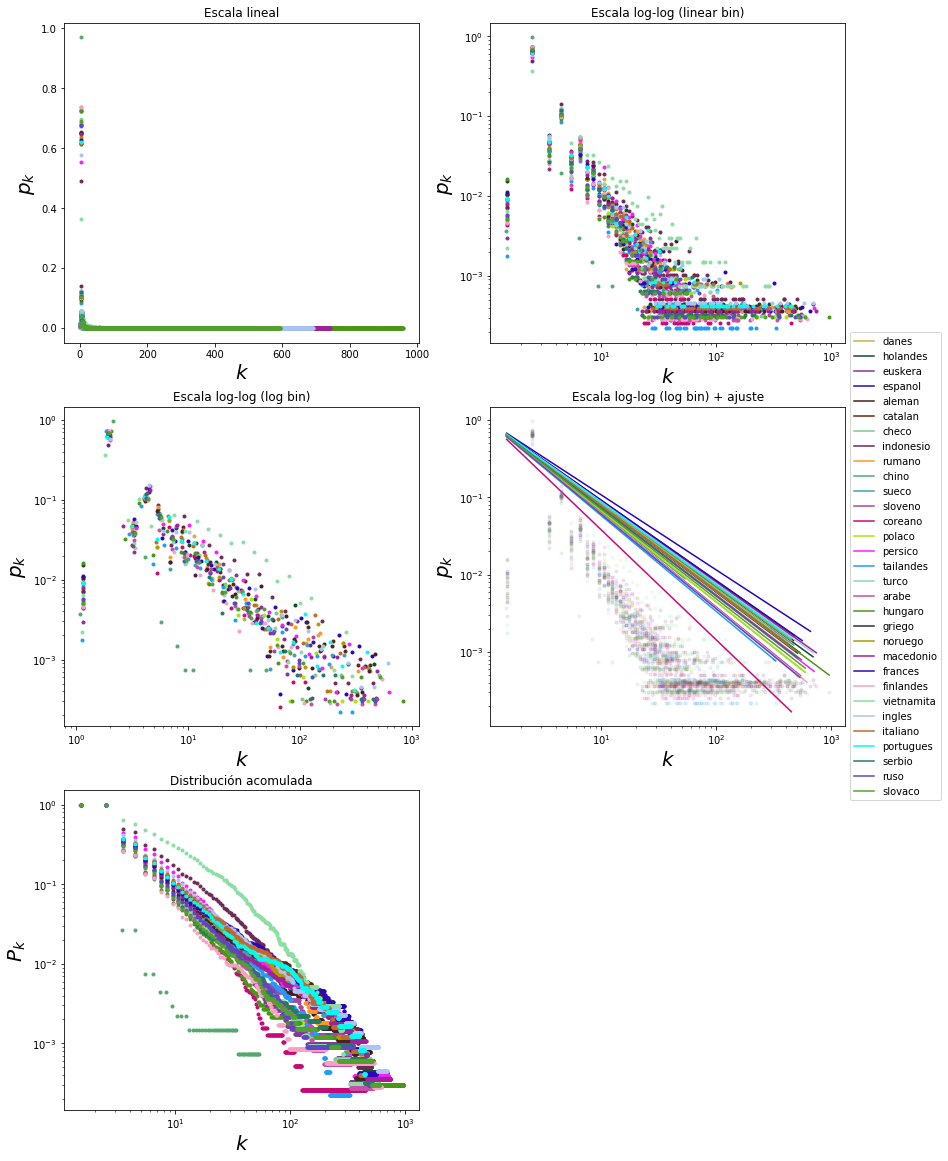

In [176]:
# se definen las funciones para graficar
def graficarEscalaLineal(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados , bins = max(grados))
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def graficarBinLinear(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados, bins = max(grados) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
def graficarBinLog(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    log_bin = np.logspace(0, np.log10(max(grados)), 25)
    y,x = np.histogram(grados, bins = log_bin )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def graficarAcum(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados, bins = max(grados) )
    y_cum = np.flip( np.cumsum( np.flip( y ) ) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y_cum/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$P_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def graficarBinLogYAjuste(G, lab, alfa, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    log_bin = np.logspace(0, np.log10(max(grados)), 25)
    y,x = np.histogram(grados, bins = max(grados) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, alpha=0.1)
    plt.plot(x_med, 1*x_med**(-alfa), color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#################################    

## configuración de gráficas
sizefont = 20
alfas = dict(zip(df['idioma'].tolist(),df[r'$\alpha_1$'].tolist()))

from random import randint
colors = []
for i in range(len(Gs)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

##################    
### se grafica ###
plt.figure(figsize = (14,20))
plt.subplot(321)

color_index = 0
for key in Gs:
    graficarEscalaLineal(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala lineal')

color_index = 0
plt.subplot(322)
for key in Gs:
    graficarBinLinear(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (linear bin)')

color_index = 0
plt.subplot(323)
for key in Gs:
    graficarBinLog(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (log bin)')

color_index = 0
plt.subplot(324)
for key in Gs:
    graficarBinLogYAjuste(Gs.get(key), key, alfas[key], colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (log bin) + ajuste')
  
color_index = 0
plt.subplot(325)
for key in Gs:
    graficarAcum(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Distribución acomulada')

plt.show()

### 4. Análisis de agrupación de las redes
Se normalizaron los datos y se aplicó un análisis de agrupamiento jerárquico a las medidas de la topología de red. Para ello se utilizó el método de Ward (este método busca la forma de reducir la varianza entre los datos y así agrupa a los que quedan más cercanos) (para los detalles del análisis ver [Liu y Cong (2013)](https://link.springer.com/article/10.1007/s11434-013-5711-8).

Los textos se clasificaron de acuerdo a distintos niveles de la clasificación de languajes en [Ethnologue](https://www.ethnologue.com/browse/families).

In [179]:
## se normalizan los datos
from sklearn import preprocessing

x = df.iloc[:,1:].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalizado = pd.DataFrame(x_scaled, columns = nombres_columnas[1:])
df_normalizado.insert( 0, 'idioma', df.idioma )

df_normalizado

,idioma,$V$,$E$,$<k>$,$L$,$C$,$D$,$NC$,$NH$,$\alpha_1$,$R^2_1$,$\alpha_2$,$R^2_2$
0,danes,0.354246,0.693755,0.387719,0.011127,0.686319,0.034483,0.534142,0.631118,0.186029,0.818755,0.554909,0.945570
1,holandes,0.293093,0.659532,0.412956,0.003051,0.873656,0.000000,0.975954,0.729511,0.239178,0.832806,0.762446,0.980645
2,euskera,0.534537,0.697636,0.276837,0.051779,0.205507,0.051724,0.512462,0.498382,0.533515,0.837780,0.468621,0.833526
3,espanol,0.434094,0.755145,0.370753,0.004117,1.000000,0.017241,0.746315,0.828604,0.000000,0.740166,0.933901,0.986654
4,aleman,0.374208,0.687287,0.368287,0.015767,0.653177,0.034483,0.628596,0.673887,0.295804,0.915441,0.700231,0.920714
5,catalan,0.318441,0.696578,0.418744,0.008380,0.808335,0.051724,0.603703,0.653747,0.156968,1.000000,0.786519,0.929165
6,checo,0.574461,0.693755,0.255089,0.045053,0.323721,0.086207,0.535768,0.637908,0.458470,0.782033,0.562270,0.779594
7,indonesio,0.198986,0.744561,0.581508,0.007136,0.699138,0.017241,0.792989,0.486373,0.319878,0.963704,0.467938,0.865851
8,rumano,0.449620,0.749383,0.356781,0.019758,0.549365,0.051724,0.491882,0.645874,0.307507,0.802755,0.705563,0.819311
9,chino,0.001901,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.481914,0.000000,0.000000,0.709483


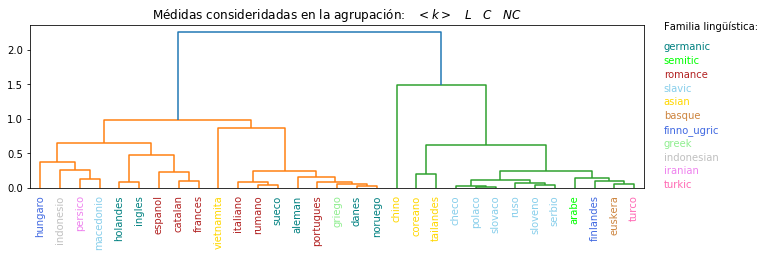

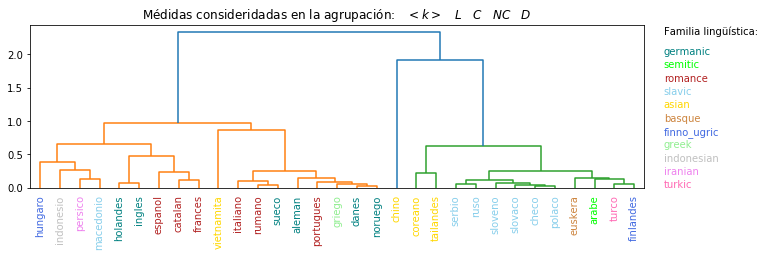

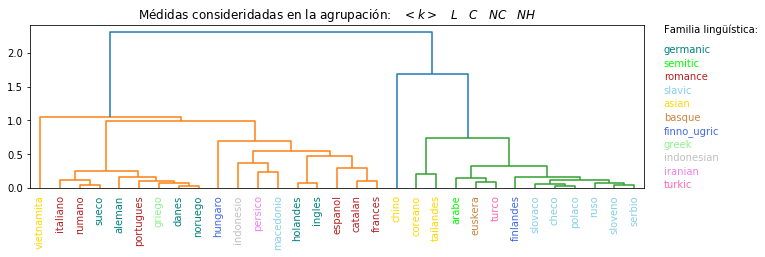

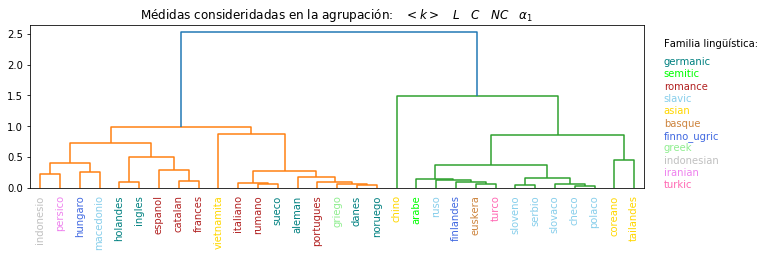

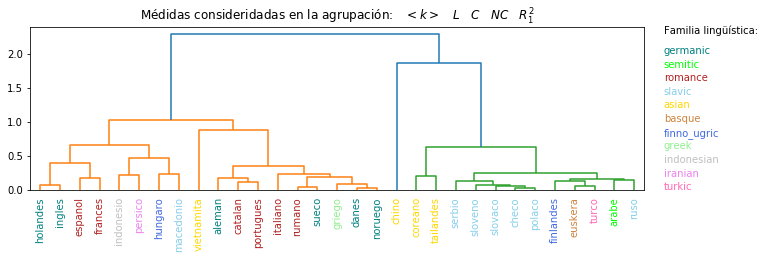

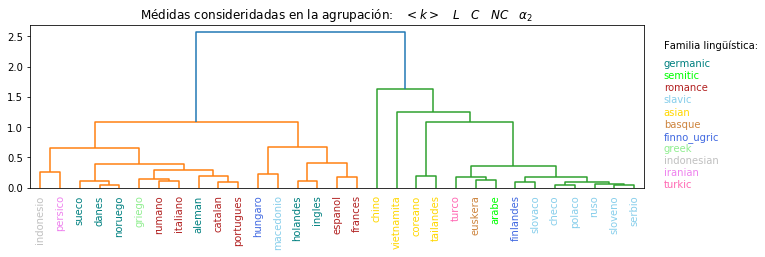

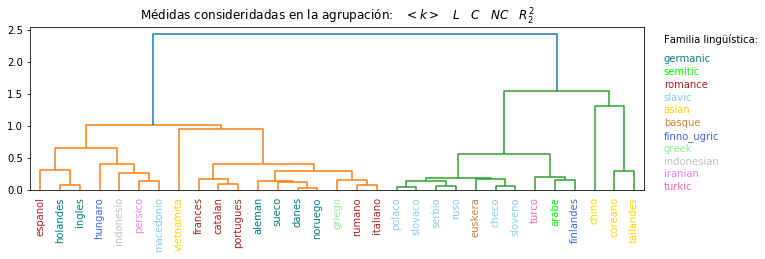

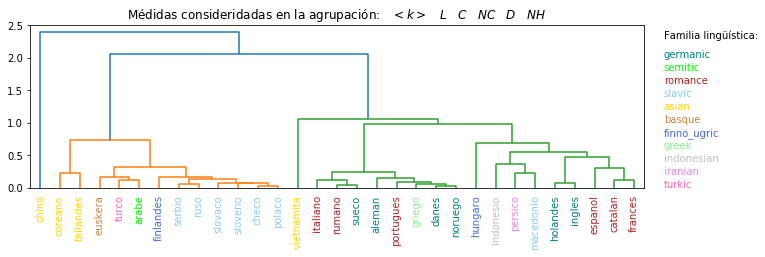

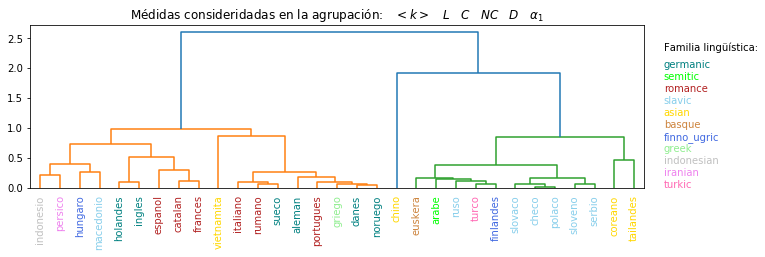

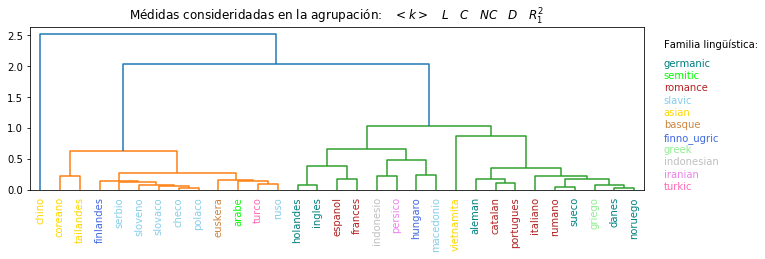

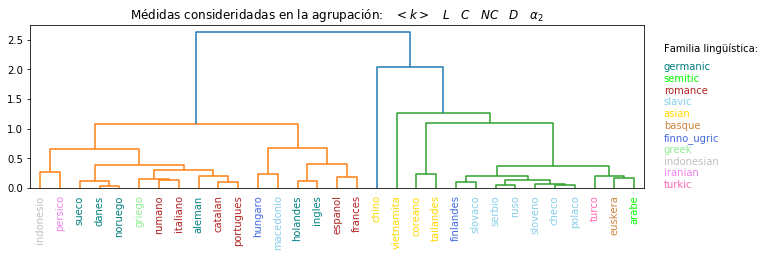

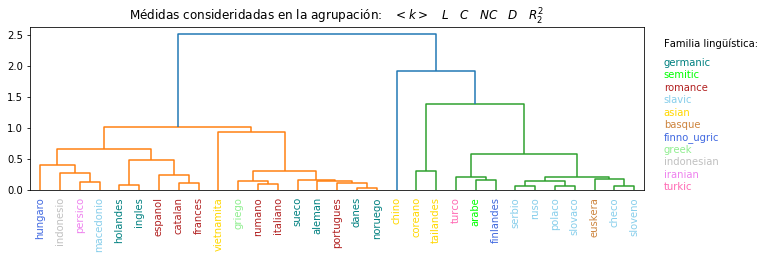

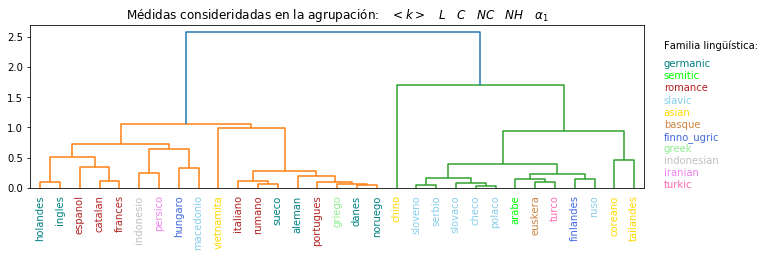

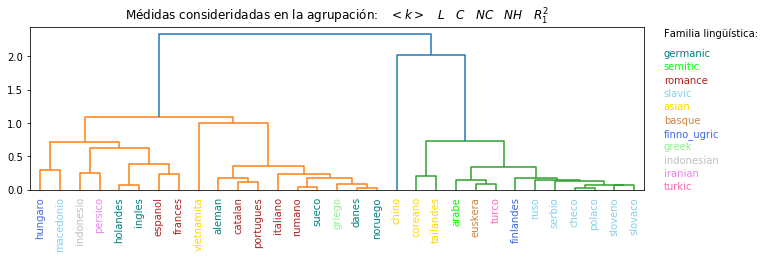

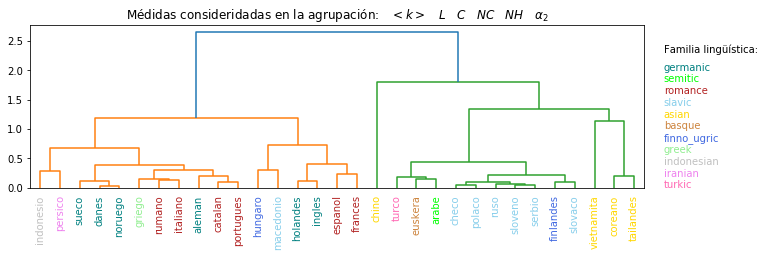

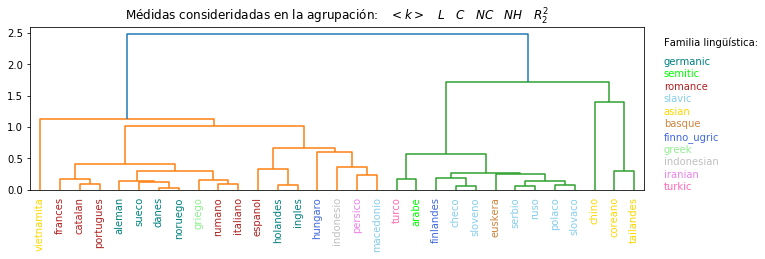

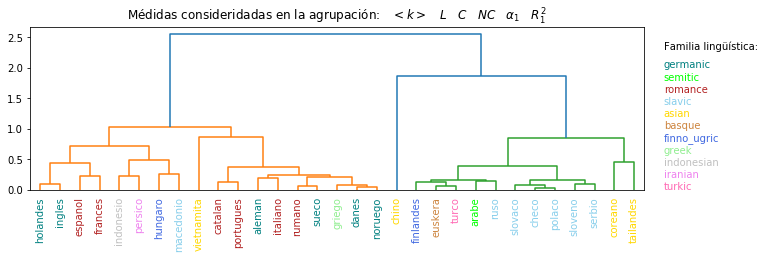

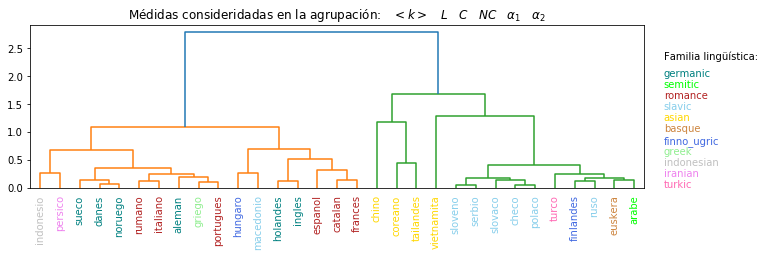

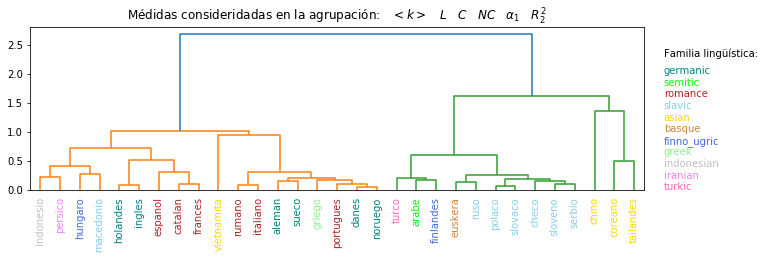

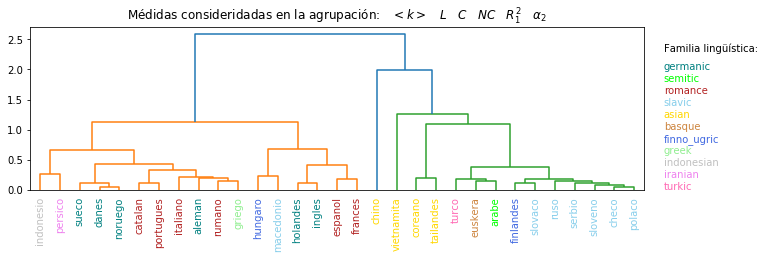

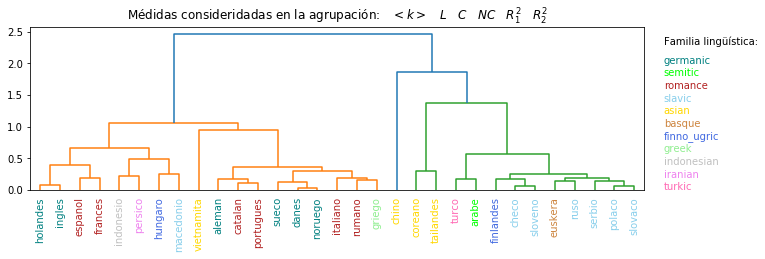

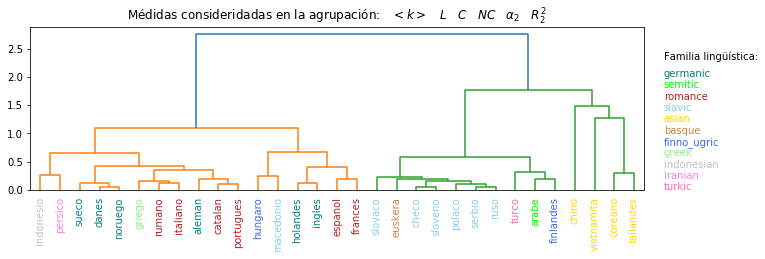

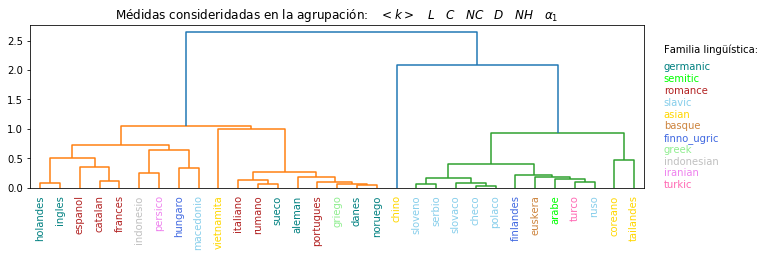

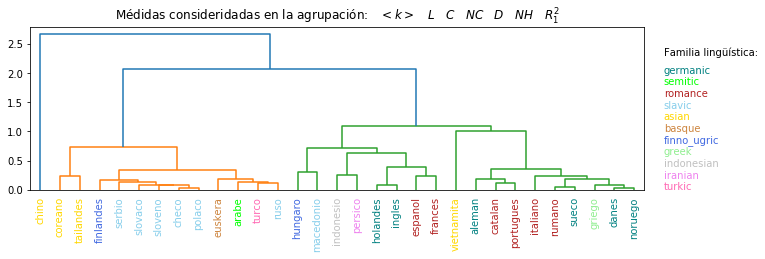

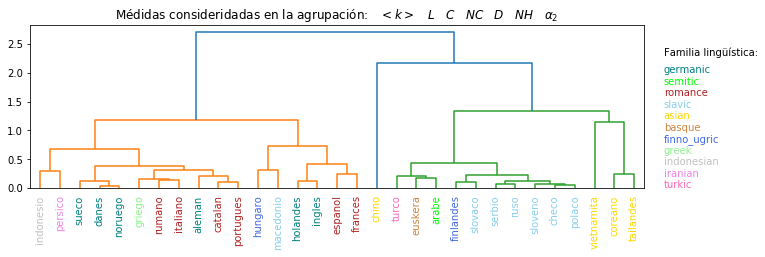

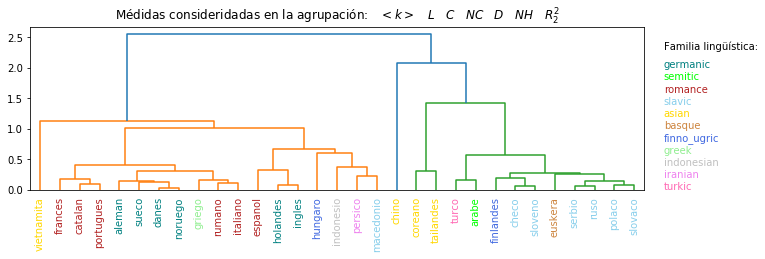

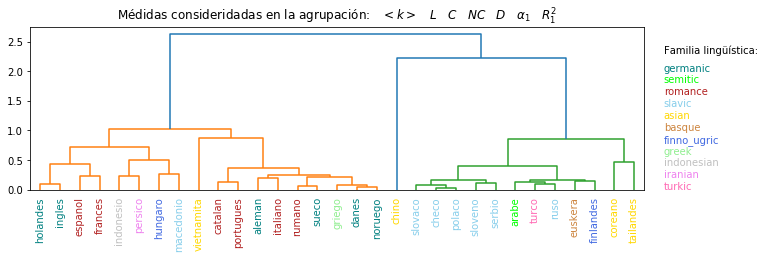

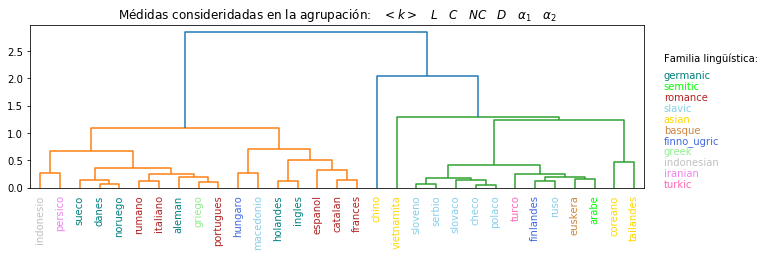

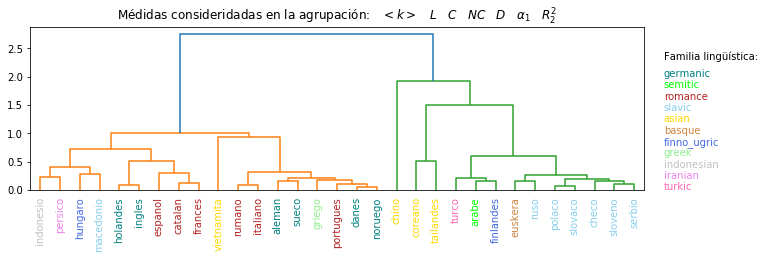

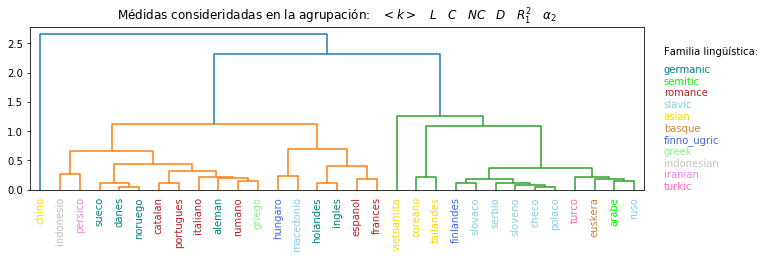

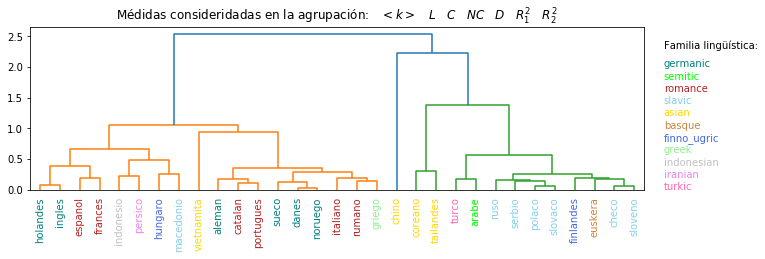

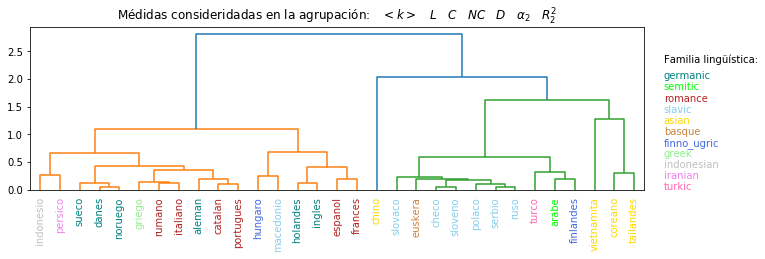

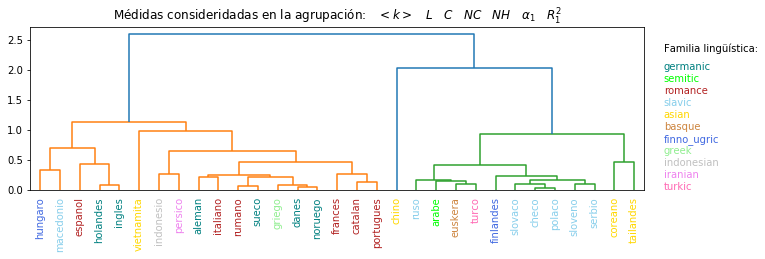

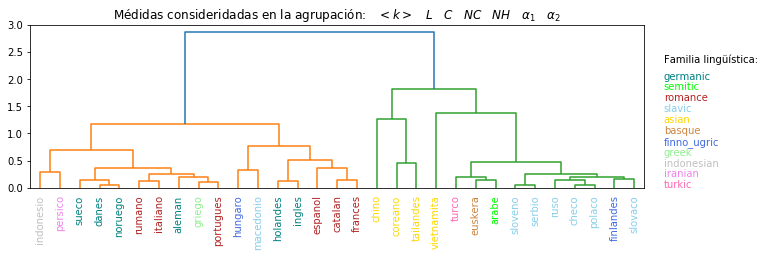

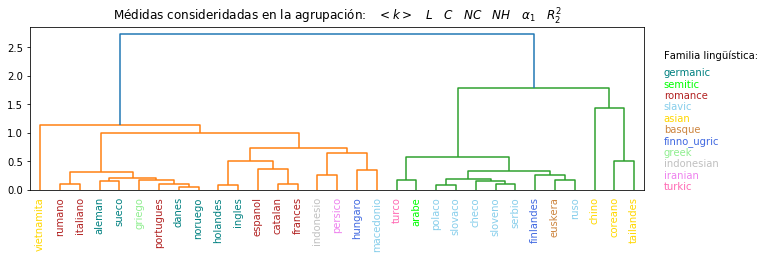

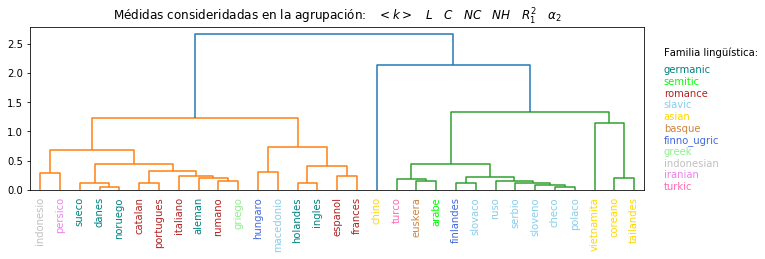

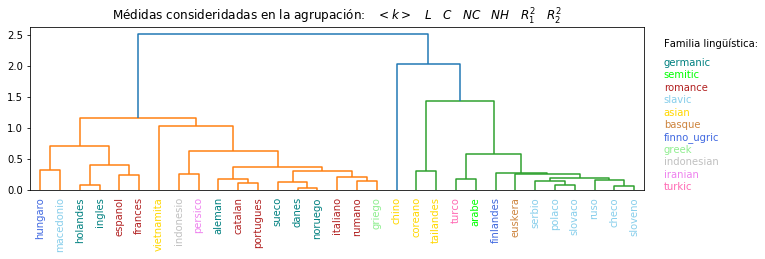

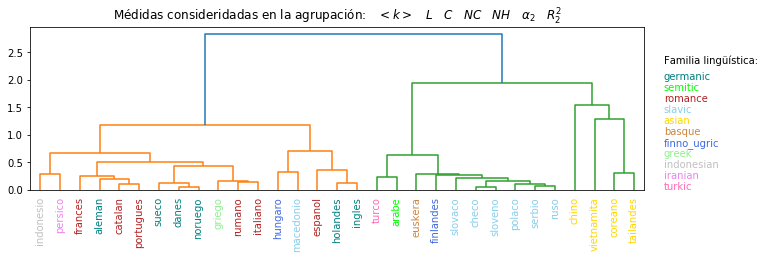

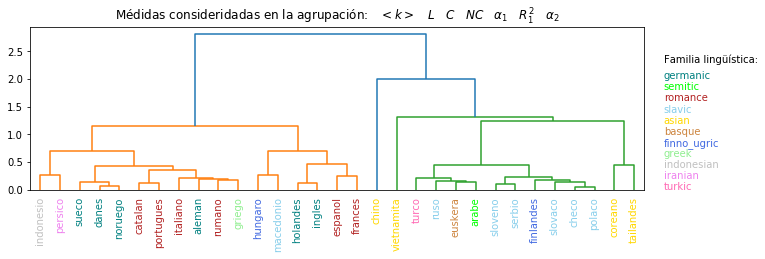

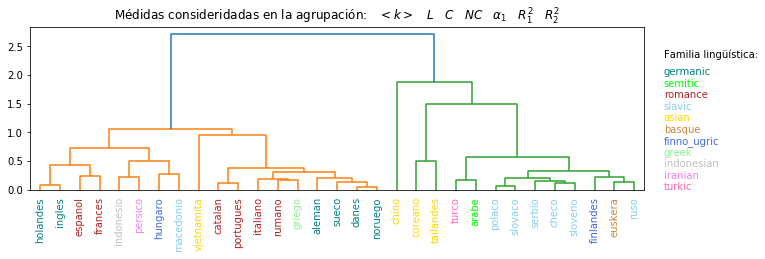

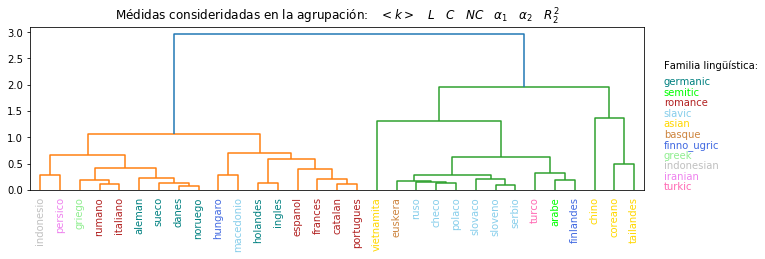

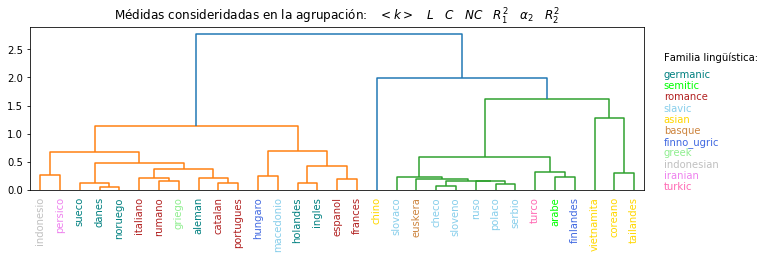

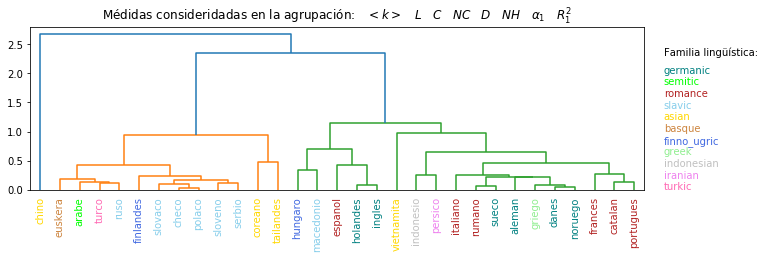

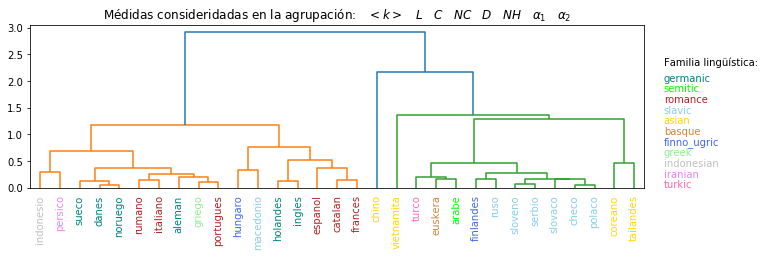

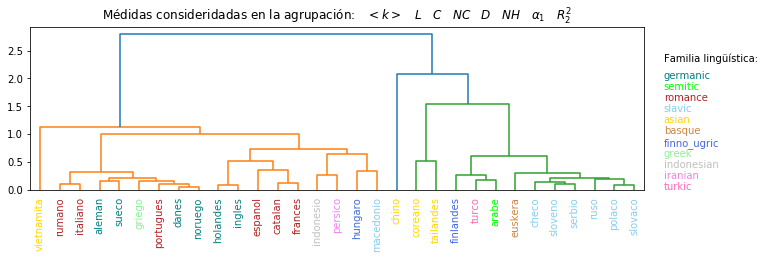

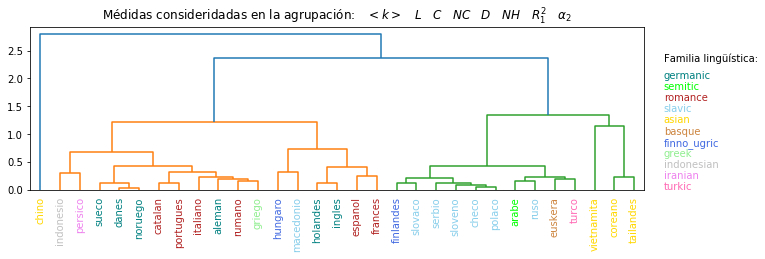

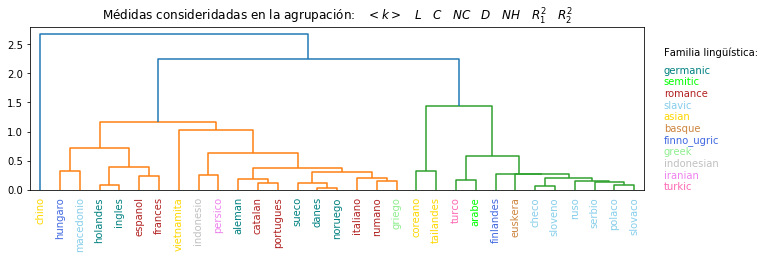

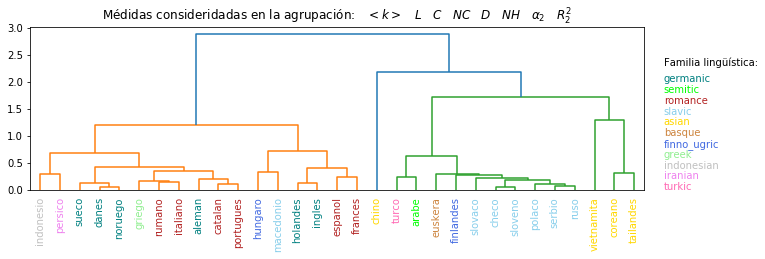

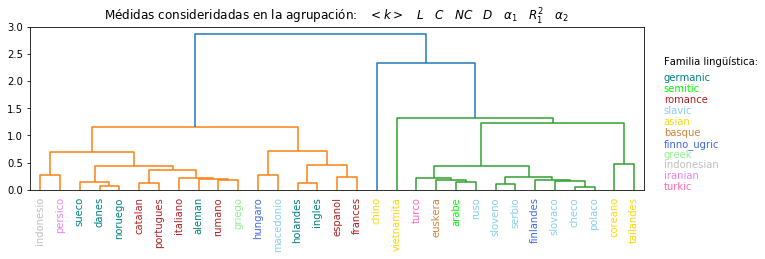

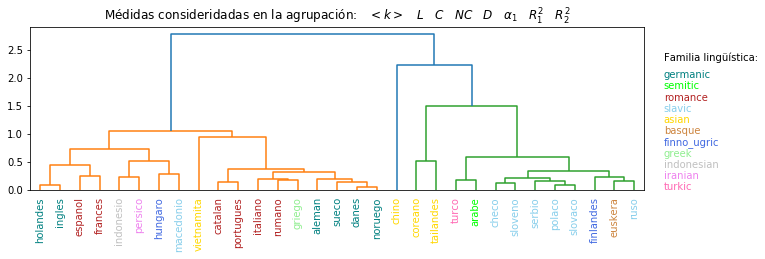

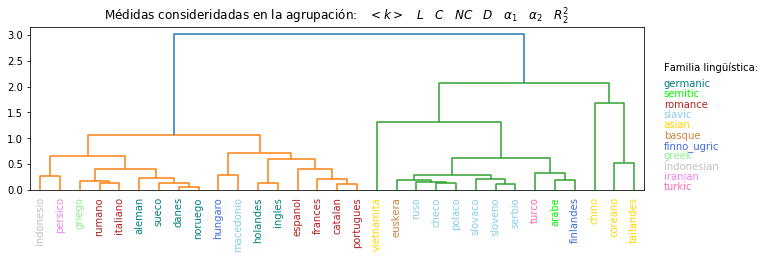

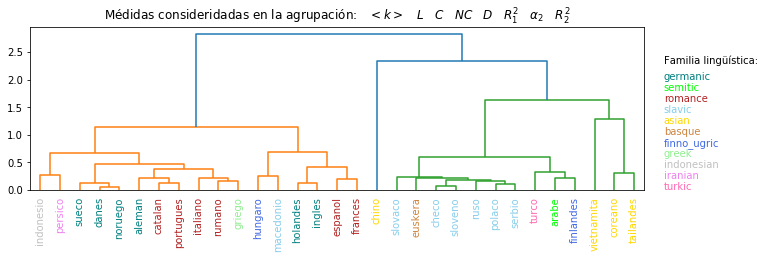

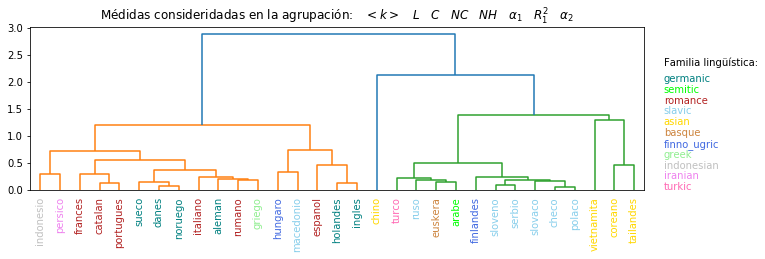

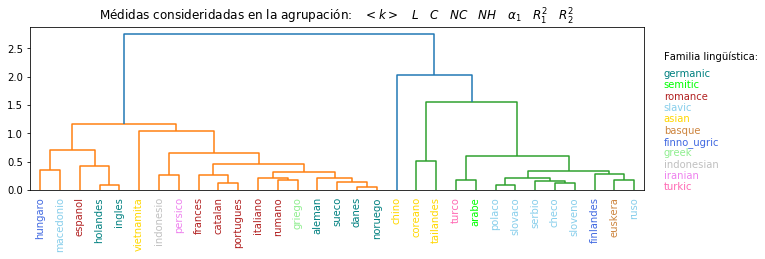

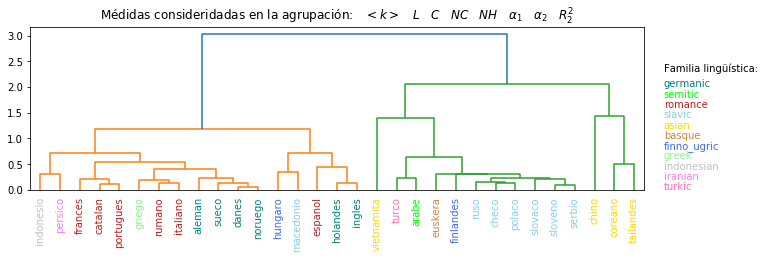

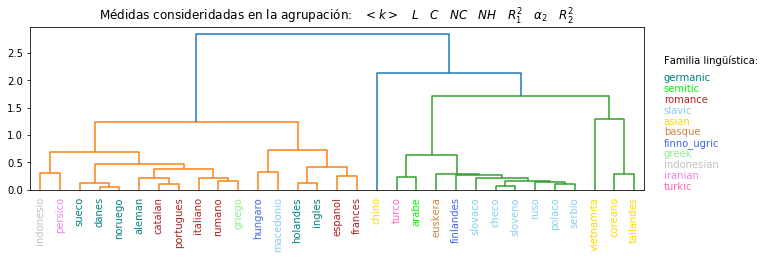

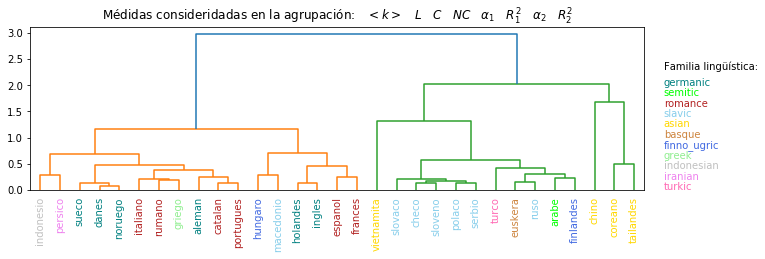

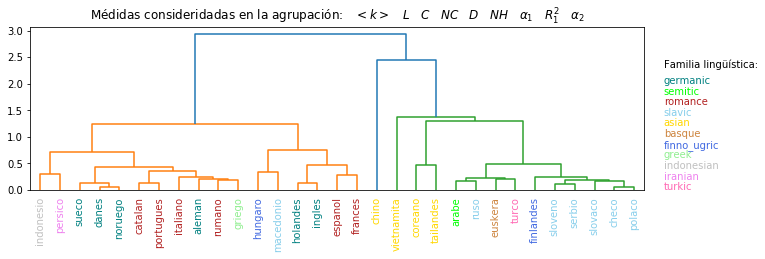

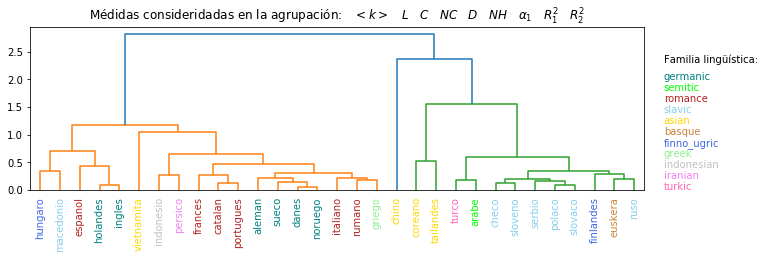

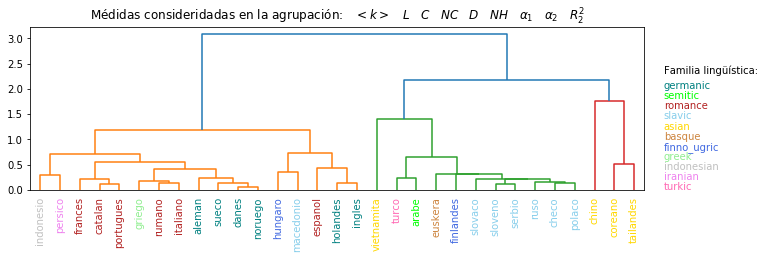

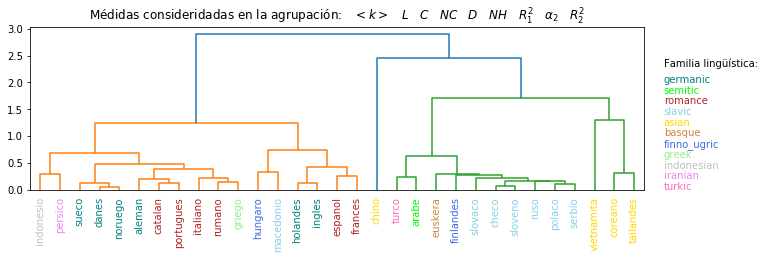

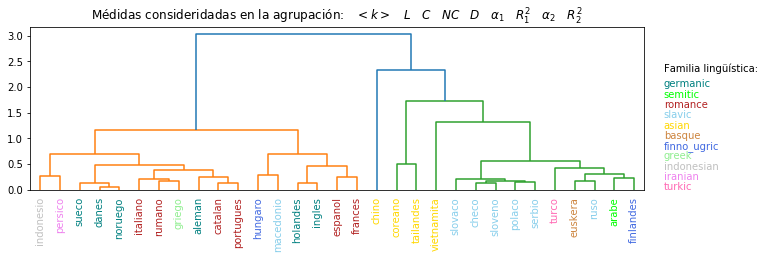

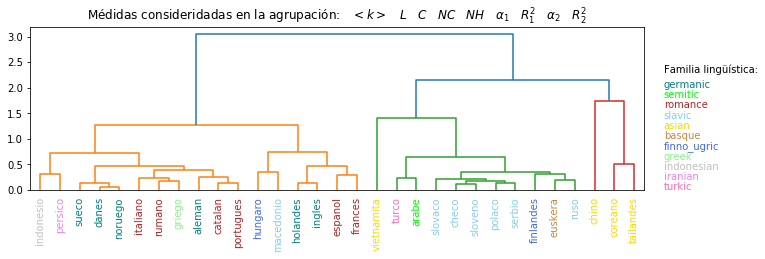

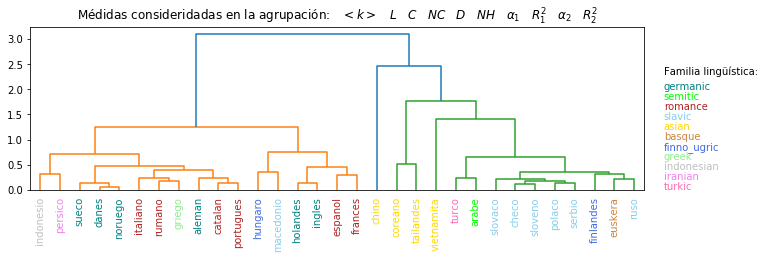

In [195]:
# se exploraron las 64 posibles combinaciones de los parametros base 
# (que se incluyen siempre) con los parámetros no base
params_base = ['$<k>$','$L$','$C$','$NC$']
params_no_base = ['$D$','$NH$',r'$\alpha_1$','$R^2_1$',r'$\alpha_2$','$R^2_2$']

from itertools import combinations
combis = sum([list(map(list, combinations(params_no_base, i))) for i in range(len(params_no_base)+ 1)], [])


## se clasifican los idiomas por familias lingüísticas 
germanic = 'teal'
semitic = 'lime'
romance = 'firebrick'
slavic ='skyblue'
asian = 'gold'
basque = 'peru'
finno_ugric = 'royalblue'
greek = 'lightgreen'
indonesian = 'silver'
iranian = 'violet'
turkic = 'hotpink'

familias = {
    'aleman': germanic,
    'arabe': semitic,
    'catalan': romance,
    'checo': slavic,
    'chino': asian,
    'coreano': asian,
    'danes': germanic,
    'espanol': romance,
    'euskera': basque,
    'finlandes': finno_ugric,
    'frances': romance,
    'griego': greek,
    'holandes': germanic,
    'hungaro': finno_ugric,
    'indonesio': indonesian,
    'ingles': germanic,
    'italiano': romance,
    'macedonio': slavic,
    'noruego': germanic,
    'persico': iranian,
    'polaco': slavic,
    'portugues': romance,
    'rumano': romance,
    'ruso': slavic,
    'serbio': slavic,
    'slovaco': slavic,
    'sloveno': slavic,
    'sueco': germanic,
    'tailandes': asian,
    'turco': turkic,
    'vietnamita': asian
}

## se aplica el análisis de agrupamiento (métdo de ward)
import scipy.cluster.hierarchy as shc

etiquetas = list(df_normalizado.idioma )

contador = 1

for combi in combis:
    medidas = params_base + combi

    data = df_normalizado.loc[:, medidas]
    contador += 1
    
    figura = plt.figure(figsize=(11,3))
    dend = shc.dendrogram(
        shc.linkage(data, method='ward'),
        labels=etiquetas,
        leaf_font_size = 10,
        leaf_rotation = 90
    )
    
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(familias[lbl.get_text()])
    y_pos = 320
    plt.text(y_pos,2.3,'Familia lingüística:')
    plt.text(y_pos,2,'germanic',color=germanic)
    plt.text(y_pos,1.8,'semitic',color=semitic)
    plt.text(y_pos,1.6,'romance',color=romance)
    plt.text(y_pos,1.4,'slavic',color=slavic)
    plt.text(y_pos,1.2,'asian',color=asian)
    plt.text(y_pos,1,'basque',color=basque)
    plt.text(y_pos,0.8,'finno_ugric',color=finno_ugric)
    plt.text(y_pos,0.6,'greek',color=greek)
    plt.text(y_pos,0.4,'indonesian',color=indonesian)
    plt.text(y_pos,0.2,'iranian',color=iranian)
    plt.text(y_pos,0,'turkic',color=turkic)
    
    titulo = 'Médidas consideridadas en la agrupación:'
    for medida in medidas:
        titulo += '   ' + medida
        
    plt.title(titulo)
    plt.show()

### No salió :(  
- Similar a lo que pasa para perdo páramo, las agrupaciones que incluyen $\alpha_1$ y $\alpha_2$ generan las mejores agrupaciones, pero igual no son agrupaciones tan chidas.
- En general el análisis no parece agrupar chido a las redes por su parentesco lingüístico
- Las únicas redes que se agrupan casi siempre son las de las lenguas eslávicas esto es igual a lo que les sale a Liu y Cong (2013)
- Las medidas más chidas para la agrupación son $\alpha_1$ y $\alpha_2$ en conjunto.
- Estas redes son más peques que las de pedroparamo por lo que talvez el tamaño de la red afecta la resolución del análisis.


### 5. Fracaso 2

Se hizo otro método de agrupación que no sé bien como funciona... y tampoco sale :(

In [196]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

n_clusters=10
model = AgglomerativeClustering(n_clusters=n_clusters,linkage="average", affinity='Cosine')

model.fit(df.iloc[:,3:])

clusteres = []
for cluster in range(n_clusters):
    clus_list = []
    for i in range(len(df.iloc[:,3:])):
        if model.labels_[i]==cluster:
            clus_list.append(df.idioma[i])
    clusteres.append(clus_list)
    
for i in range(len(clusteres)):
    print('Cluster '+ str(i) + ' = ' + str(clusteres[i]) )

Cluster 0 = ['euskera', 'checo', 'sloveno', 'polaco', 'tailandes']
Cluster 1 = ['turco', 'arabe', 'finlandes', 'serbio', 'ruso', 'slovaco']
Cluster 2 = ['danes', 'aleman', 'catalan', 'rumano', 'sueco', 'persico', 'griego', 'noruego', 'macedonio']
Cluster 3 = ['hungaro']
Cluster 4 = ['indonesio']
Cluster 5 = ['vietnamita']
Cluster 6 = ['holandes', 'frances', 'ingles', 'italiano', 'portugues']
Cluster 7 = ['chino']
Cluster 8 = ['coreano']
Cluster 9 = ['espanol']


### 6. Texto aleatorio

Se genera un texto a partir una caminata aleatoria en una red dirigida del texto. El texto que se genera es sintacticamente correcto pero semanticamente no.

In [197]:
# se contruyen redes dirigidas y se genera un texto con una caminata aleatoria
DGs = {}

for idioma, enlaces in textos.items():
    DGs[idioma] = nx.DiGraph(enlaces) 

palabra = random.choice(list(DGs['espanol'].nodes()))
lista_caminata_aleatoria = [palabra]

for i in range(100):
    siguiente = random.choice(list(DGs['espanol'][palabra]))
    lista_caminata_aleatoria.append(siguiente)
    palabra = siguiente

cadena = ''
for palabra in lista_caminata_aleatoria:
    if palabra != '.':
        cadena = cadena + ' ' + palabra
    else:
        cadena = cadena + palabra

texto = ''

for oracion in cadena.split('.'):
    if len(oracion) >= 2:
        oracion = oracion[1].upper() + oracion[2:] + '.'
    texto = texto + ' ' + oracion

print(texto)

 Provecho de alta moral la renta del deber general según las demás. Nosotros no advierte que hicieron más indignante cuanta mayor rapidez posible la seguridad de transformaciones radicales franceses. Aglomera la prostitución oficial sienten una literatura francesa revolucionaria por los proletarios en todos luchan contra aquellos sectores de burgueses no hace más la capa más fáciles de condiciones sociales habían sido crear nuevas viene a ser un plan más pujante. Al oírnos proclamar el liberalismo contra sí al explotar el librecambio la oposicion después de comunidad de existir para comprender la conciencia en modo se ponen de prensa.
